# Generating a map of meat and dairy processing facilities in Brazil
## This code gets data from the Federal Inspection Service (SIF), containing information on meat and dairy plants across the country.

The data was already downloaded as an Excel sheet. It can be obtained by submitting a request to the Ministry of Agriculture. The `pandas`, `geopandas` and `matplotlib` libraries will be needed for this notebook, as well as the `opencage` library, developed by the [OpenCage Project](https://opencagedata.com/), which provides open-access geocoding.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from opencage.geocoder import OpenCageGeocode

%matplotlib inline

Read the spreadsheet with `pandas`

In [2]:
sif_data = pd.read_excel('Estabelecimentos_sob_SIF_ativos._16.09.2021.xls')
sif_data

,UF,MUNICIPIO,SIF,SIPOA,RAZAO SOCIAL,CATEGORIA,CLASSE,AREA,Estabelecimentos Registrados
0,AC,BRASILÉIA,2524,1º SIPOA,DOM PORQUITO AGROINDUSTRIAL S/A,ABATEDOURO FRIGORÍFICO,SUÍNO - 400 A 800/D,CARNE,1
1,AC,RIO BRANCO,3919,1º SIPOA,CURTUME KOROBRÁS LTDA,UNIDADE DE BENEF. DE PROD. NÃO COMESTÍVEIS,FÁBRICA DE PRODUTO NÃO COMESTÍVEL,NÃO COMESTÍVEL,1
2,AC,RIO BRANCO,3297,1º SIPOA,FRISACRE FRIGORIFICO SANTO AFONSO DO ACRE LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
3,AC,RIO BRANCO,2951,1º SIPOA,JBS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - mais de 80/h,CARNE,1
4,AC,SENADOR GUIOMARD,4086,1º SIPOA,FRIGORIFICO NOSSO LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
...,...,...,...,...,...,...,...,...,...
3462,TO,PARAÍSO DO TOCANTINS,3215,3º SIPOA,PLENA ALIMENTOS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
3463,TO,PARAÍSO DO TOCANTINS,1840,3º SIPOA,PARAISO PET NUTRICAO ANIMAL LTDA,UNIDADE DE BENEF. DE PROD. NÃO COMESTÍVEIS,FÁBRICA DE PRODUTO NÃO COMESTÍVEL,NÃO COMESTÍVEL,1
3464,TO,PORTO NACIONAL,1362,3º SIPOA,PORTO RECICLAGEM ANIMAL LTDA,UNIDADE DE BENEF. DE PROD. NÃO COMESTÍVEIS,FÁBRICA DE PRODUTO NÃO COMESTÍVEL,NÃO COMESTÍVEL,1
3465,TO,SANTA FÉ DO ARAGUAIA,3434,3º SIPOA,LATICÍNIOS MINAS QUEIJO INDÚSTRIA E COMÉRCIO LTDA,UNIDADE DE BENEFICIAMENTO DE LEITE E DERIVADOS,EST.LEITE E DERIV. (20.000 A 50.000 L/DIA),LEITE,1


The dataframe has no information on latitude or longitude of each plant, so geocoding will be necessary to generate the map. First, insert two empty columns in the dataframe.

In [3]:
sif_data.insert(2,'Latitude',float('NaN'))
sif_data.insert(3,'Longitude',float('NaN'))
sif_data.head()

,UF,MUNICIPIO,Latitude,Longitude,SIF,SIPOA,RAZAO SOCIAL,CATEGORIA,CLASSE,AREA,Estabelecimentos Registrados
0,AC,BRASILÉIA,NaN,NaN,2524,1º SIPOA,DOM PORQUITO AGROINDUSTRIAL S/A,ABATEDOURO FRIGORÍFICO,SUÍNO - 400 A 800/D,CARNE,1
1,AC,RIO BRANCO,NaN,NaN,3919,1º SIPOA,CURTUME KOROBRÁS LTDA,UNIDADE DE BENEF. DE PROD. NÃO COMESTÍVEIS,FÁBRICA DE PRODUTO NÃO COMESTÍVEL,NÃO COMESTÍVEL,1
2,AC,RIO BRANCO,NaN,NaN,3297,1º SIPOA,FRISACRE FRIGORIFICO SANTO AFONSO DO ACRE LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
3,AC,RIO BRANCO,NaN,NaN,2951,1º SIPOA,JBS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - mais de 80/h,CARNE,1
4,AC,SENADOR GUIOMARD,NaN,NaN,4086,1º SIPOA,FRIGORIFICO NOSSO LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1


Not every facility in this spreadsheet is of interest. The current research focuses only on slaughterhouses and dairy plants, so it is necessary to list all the categories in the dataframe.

In [4]:
sif_categories = sif_data['CATEGORIA'].unique()
print(sif_categories)

['ABATEDOURO FRIGORÍFICO' 'UNIDADE DE BENEF. DE PROD. NÃO COMESTÍVEIS'
 'UNIDADE DE BENEF. DE PESCADO E PROD. DE PESCADO'
 'UNIDADE DE BENEF. DE CARNE E PROD. CÁRNEOS' 'GRANJA AVICOLA'
 'UNIDADE DE BENEFICIAMENTO DE LEITE E DERIVADOS'
 'UNIDADE DE BENEFICIAMENTO DE PRODUTOS DE ABELHAS'
 'ABATEDOURO FRIGORÍFICO DE PESCADO'
 'UNIDADE DE BENEF. DE OVOS E DERIVADOS' 'POSTO DE REFRIGERACAO'
 'ENTREPOSTO DE PRODUTOS DE ORIGEM ANIMAL' 'USINA DE BENEFICIAMENTO'
 'ENTREPOSTO BENEF. DE PROD. DE ABELHAS E DERIVADOS' 'QUEIJARIA'
 'FABRICA DE LATICINIOS' 'GRANJA LEITEIRA'
 'UNIDADE DE EXTRAÇÃO E BENEF. DE PROD. DE ABELHAS' 'BARCO FÁBRICA'
 'FABRICA DE PRODUTOS GORDUROSOS']


Now, select only slaugtherhouses and dairy plants

In [5]:
sif_data = sif_data.loc[sif_data['CATEGORIA'].isin(sif_categories[[0,5,13,14]])].copy()
sif_data.index = range(0,len(sif_data))
sif_data

,UF,MUNICIPIO,Latitude,Longitude,SIF,SIPOA,RAZAO SOCIAL,CATEGORIA,CLASSE,AREA,Estabelecimentos Registrados
0,AC,BRASILÉIA,NaN,NaN,2524,1º SIPOA,DOM PORQUITO AGROINDUSTRIAL S/A,ABATEDOURO FRIGORÍFICO,SUÍNO - 400 A 800/D,CARNE,1
1,AC,RIO BRANCO,NaN,NaN,3297,1º SIPOA,FRISACRE FRIGORIFICO SANTO AFONSO DO ACRE LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
2,AC,RIO BRANCO,NaN,NaN,2951,1º SIPOA,JBS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - mais de 80/h,CARNE,1
3,AC,SENADOR GUIOMARD,NaN,NaN,4086,1º SIPOA,FRIGORIFICO NOSSO LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
4,AC,TARAUACÁ,NaN,NaN,3652,1º SIPOA,"FRIGORDO INDÚSTRIA, COMÉRCIO, IMPORTAÇÃO E EXP...",ABATEDOURO FRIGORÍFICO,BOVINO - 40 a 80/h,CARNE,1
...,...,...,...,...,...,...,...,...,...,...,...
1451,TO,ITAPORÃ DO TOCANTINS,NaN,NaN,2461,3º SIPOA,NILTON D. DA SILVA,FABRICA DE LATICINIOS,EST.LEITE E DERIV.(10.000A20.000),LEITE,1
1452,TO,NOVA OLINDA,NaN,NaN,860,3º SIPOA,MASTERBOI LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 40 a 80/h,CARNE,1
1453,TO,PARAÍSO DO TOCANTINS,NaN,NaN,4625,3º SIPOA,FRIGORIFICO PARAISO EIRELI,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
1454,TO,PARAÍSO DO TOCANTINS,NaN,NaN,3215,3º SIPOA,PLENA ALIMENTOS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1


With 1456 of 3467 rows selected, it is now time to connect to OpenCage using the `opencage` library. An API key is required.

In [6]:
key='YOUR-API-KEY'
geocoder = OpenCageGeocode(key)

Now, go through each row of the dataframe, getting latitude and longitude. But first, it is necessary to translate Brazilian state codes to state names, since statecodes do not seem to work properly with opencage yet.

In [7]:
# Create a dictionary of Brazilian state codes and names
br_states_dict = {'RS' : 'Rio Grande do Sul',
                 'SC' : 'Santa Catarina',
                 'PR' : 'Paraná',
                 'SP' : 'São Paulo',
                 'RJ' : 'Rio de Janeiro',
                 'ES' : 'Espírito Santo',
                 'MG' : 'Minas Gerais',
                 'MS' : 'Mato Grosso do Sul',
                 'MT' : 'Mato Grosso',
                 'GO' : 'Goiás',
                 'DF' : 'Distrito Federal',
                 'BA' : 'Bahia',
                 'SE' : 'Sergipe',
                 'AL' : 'Alagoas',
                 'PE' : 'Pernambuco',
                 'PB' : 'Paraíba',
                 'RN' : 'Rio Grande do Norte',
                 'CE' : 'Ceará',
                 'PI' : 'Piauí',
                 'MA' : 'Maranhão',
                 'TO' : 'Tocantins',
                 'PA' : 'Pará',
                 'AP' : 'Amapá',
                 'AM' : 'Amazonas',
                 'RR' : 'Roraima',
                 'AC' : 'Acre',
                 'RO' : 'Rondônia'}

Loop to get geocoding coordinates from each city in the dataframe

In [8]:
for i in sif_data.index:
    cityname = sif_data.loc[i,'MUNICIPIO']
    statecode = br_states_dict[sif_data.loc[i,'UF']]    
    address = ','.join([cityname, statecode, 'Brazil'])     
    results = geocoder.geocode(address) 
    citylat = results[0]['geometry']['lat'] 
    citylong = results[0]['geometry']['lng']
    sif_data.loc[i,'Latitude'] = citylat    
    sif_data.loc[i,'Longitude'] = citylong  
    #Print actual location with geocoding result, to check if everything went well
    print(f"Query = {address} /// Result = {results[0]['formatted']}")
    
sif_data.to_excel('SIF_data_selected_with_coords.xlsx')    
sif_data.head()

Query = BRASILÉIA,Acre,Brazil /// Result = Brasiléia - AC, 69932-000, Brazil
Query = RIO BRANCO,Acre,Brazil /// Result = Rio Branco, Região Geográfica Intermediária de Rio Branco, Brazil
Query = RIO BRANCO,Acre,Brazil /// Result = Rio Branco, Região Geográfica Intermediária de Rio Branco, Brazil
Query = SENADOR GUIOMARD,Acre,Brazil /// Result = Senador Guiomard, Região Geográfica Intermediária de Rio Branco, Brazil
Query = TARAUACÁ,Acre,Brazil /// Result = Tarauacá, Região Geográfica Intermediária de Cruzeiro do Sul, Brazil
Query = ARAPIRACA,Alagoas,Brazil /// Result = Arapiraca, Região Geográfica Intermediária de Arapiraca, Brazil
Query = BATALHA,Alagoas,Brazil /// Result = Batalha, Região Geográfica Intermediária de Arapiraca, Brazil
Query = MURICI,Alagoas,Brazil /// Result = Murici, Região Geográfica Intermediária de Maceió, Brazil
Query = PALMEIRA DOS ÍNDIOS,Alagoas,Brazil /// Result = Palmeira dos Índios, Região Geográfica Intermediária de Arapiraca, Brazil
Query = PALMEIRA DOS ÍN

Query = CACHOEIRO DE ITAPEMIRIM,Espírito Santo,Brazil /// Result = Cachoeiro de Itapemirim, Região Geográfica Intermediária de Cachoeiro de Itapemirim, Brazil
Query = CARIACICA,Espírito Santo,Brazil /// Result = Cariacica, Greater Vitória, Brazil
Query = CARIACICA,Espírito Santo,Brazil /// Result = Cariacica, Greater Vitória, Brazil
Query = CASTELO,Espírito Santo,Brazil /// Result = Castelo, Região Geográfica Intermediária de Cachoeiro de Itapemirim, Brazil
Query = COLATINA,Espírito Santo,Brazil /// Result = Colatina, Região Geográfica Intermediária de Colatina, Brazil
Query = DOMINGOS MARTINS,Espírito Santo,Brazil /// Result = Domingos Martins, Região Geográfica Intermediária de Vitória, Brazil
Query = ECOPORANGA,Espírito Santo,Brazil /// Result = Ecoporanga - ES, 29850-000, Brazil
Query = GUAÇUÍ,Espírito Santo,Brazil /// Result = Guaçuí, Região Geográfica Intermediária de Cachoeiro de Itapemirim, Brazil
Query = ITAGUAÇU,Espírito Santo,Brazil /// Result = Itaguaçu, Região Geográfica I

Query = MARA ROSA,Goiás,Brazil /// Result = Mara Rosa, Região Geográfica Intermediária de Porangatu-Uruaçu, Brazil
Query = MATRINCHÃ,Goiás,Brazil /// Result = Matrinchã, Região Geográfica Intermediária de Goiânia, Brazil
Query = MINEIROS,Goiás,Brazil /// Result = Mineiros, Região Geográfica Intermediária de Rio Verde, Brazil
Query = MINEIROS,Goiás,Brazil /// Result = Mineiros, Região Geográfica Intermediária de Rio Verde, Brazil
Query = MORRINHOS,Goiás,Brazil /// Result = Morrinhos - GO, 75650-000, Brazil
Query = MOZARLÂNDIA,Goiás,Brazil /// Result = Mozarlândia, Região Geográfica Intermediária de Goiânia, Brazil
Query = NOVA VENEZA,Goiás,Brazil /// Result = Nova Veneza, Região Geográfica Intermediária de Goiânia, Brazil
Query = NOVO GAMA,Goiás,Brazil /// Result = Novo Gama, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Brazil
Query = NOVO GAMA,Goiás,Brazil /// Result = Novo Gama, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Brazil
Query = ORI

Query = ANDRELÂNDIA,Minas Gerais,Brazil /// Result = Andrelândia, Minas Gerais, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ANTÔNIO CARLOS,Minas Gerais,Brazil /// Result = Antônio Carlos - MG, 36220-000, Brazil
Query = ARAGUARI,Minas Gerais,Brazil /// Result = Araguari, Região Geográfica Intermediária de Uberlândia, Brazil
Query = ARAGUARI,Minas Gerais,Brazil /// Result = Araguari, Região Geográfica Intermediária de Uberlândia, Brazil
Query = ARAGUARI,Minas Gerais,Brazil /// Result = Araguari, Região Geográfica Intermediária de Uberlândia, Brazil
Q

Query = COIMBRA,Minas Gerais,Brazil /// Result = Coimbra - MG, 36550-000, Brazil
Query = COLUNA,Minas Gerais,Brazil /// Result = Coluna, Região Geográfica Intermediária de Governador Valadares, Brazil
Query = COMERCINHO,Minas Gerais,Brazil /// Result = Comercinho, Região Geográfica Intermediária de Teófilo Otoni, Brazil
Query = CONCEIÇÃO DAS PEDRAS,Minas Gerais,Brazil /// Result = Conceição das Pedras, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = CONCEIÇÃO DO PARÁ,Minas Gerais,Brazil /// Result = Conceição do Pará, Região Geográfica Intermediária de Divinópolis, Brazil
Query = CONCEIÇÃO DO RIO VERDE,Minas Gerais,Brazil /// Result = Conceição do Rio Verde, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = CONCEIÇÃO DO RIO VERDE,Minas Gerais,Brazil /// Result = Conceição do Rio Verde, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = CONSELHEIRO LAFAIETE,Minas Gerais,Brazil /// Result = Conselheiro Lafaiete, Minas Gerais, Brazil
Query = CONS

Query = ITABIRINHA DE MANTENA,Minas Gerais,Brazil /// Result = Itabirinha, Região Geográfica Intermediária de Governador Valadares, Brazil
Query = ITABIRITO,Minas Gerais,Brazil /// Result = Itabirito, Região Geográfica Intermediária de Belo Horizonte, Brazil
Query = ITAJUBÁ,Minas Gerais,Brazil /// Result = Itajubá, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = ITAJUBÁ,Minas Gerais,Brazil /// Result = Itajubá, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = ITAMBACURI,Minas Gerais,Brazil /// Result = Itambacuri - MG, 39830-000, Brazil
Query = ITAMBACURI,Minas Gerais,Brazil /// Result = Itambacuri - MG, 39830-000, Brazil
Query = ITAMONTE,Minas Gerais,Brazil /// Result = Itamonte, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = ITAMONTE,Minas Gerais,Brazil /// Result = Itamonte, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = ITAMONTE,Minas Gerais,Brazil /// Result = Itamonte, Região Geográfica Intermediária de Pouso Alegre

Query = MENDES PIMENTEL,Minas Gerais,Brazil /// Result = Mendes Pimentel, Região Geográfica Intermediária de Governador Valadares, Brazil
Query = MERCÊS,Minas Gerais,Brazil /// Result = Mercês, Minas Gerais, Brazil
Query = MIRAÍ,Minas Gerais,Brazil /// Result = Miraí, Minas Gerais, Brazil
Query = MIRAÍ,Minas Gerais,Brazil /// Result = Miraí, Minas Gerais, Brazil
Query = MOEDA,Minas Gerais,Brazil /// Result = Moeda, Região Geográfica Intermediária de Belo Horizonte, Brazil
Query = MONTE BELO,Minas Gerais,Brazil /// Result = Monte Belo, Região Geográfica Intermediária de Varginha, Brazil
Query = MONTE BELO,Minas Gerais,Brazil /// Result = Monte Belo, Região Geográfica Intermediária de Varginha, Brazil
Query = MONTE SIÃO,Minas Gerais,Brazil /// Result = Monte Sião - MG, 37580-000, Brazil
Query = MONTES CLAROS,Minas Gerais,Brazil /// Result = Montes Claros, Região Geográfica Intermediária de Montes Claros, Brazil
Query = MONTES CLAROS,Minas Gerais,Brazil /// Result = Montes Claros, Região 

Query = POÇO FUNDO,Minas Gerais,Brazil /// Result = Poço Fundo, Região Geográfica Intermediária de Varginha, Brazil
Query = POÇOS DE CALDAS,Minas Gerais,Brazil /// Result = Poços de Caldas, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = POÇOS DE CALDAS,Minas Gerais,Brazil /// Result = Poços de Caldas, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = POÇOS DE CALDAS,Minas Gerais,Brazil /// Result = Poços de Caldas, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = POÇOS DE CALDAS,Minas Gerais,Brazil /// Result = Poços de Caldas, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = PONTE NOVA,Minas Gerais,Brazil /// Result = Ponte Nova, Minas Gerais, Brazil
Query = PONTE NOVA,Minas Gerais,Brazil /// Result = Ponte Nova, Minas Gerais, Brazil
Query = PORTEIRINHA,Minas Gerais,Brazil /// Result = Porteirinha, Região Geográfica Intermediária de Montes Claros, Brazil
Query = POTÉ,Minas Gerais,Brazil /// Result = Poté, Região Geográfica I

Query = SÃO PEDRO DOS FERROS,Minas Gerais,Brazil /// Result = São Pedro dos Ferros, Minas Gerais, Brazil
Query = SÃO ROQUE DE MINAS,Minas Gerais,Brazil /// Result = São Roque de Minas, Região Geográfica Intermediária de Varginha, Brazil
Query = SÃO SEBASTIÃO DA BELA VISTA,Minas Gerais,Brazil /// Result = São Sebastião da Bela Vista, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = SÃO SEBASTIÃO DO OESTE,Minas Gerais,Brazil /// Result = São Sebastião do Oeste, Região Geográfica Intermediária de Divinópolis, Brazil
Query = SÃO SEBASTIÃO DO PARAÍSO,Minas Gerais,Brazil /// Result = São Sebastião do Paraíso - MG, 37950-000, Brazil
Query = SÃO SEBASTIÃO DO PARAÍSO,Minas Gerais,Brazil /// Result = São Sebastião do Paraíso - MG, 37950-000, Brazil
Query = SÃO SEBASTIÃO DO RIO VERDE,Minas Gerais,Brazil /// Result = São Sebastião do Rio Verde, Região Geográfica Intermediária de Pouso Alegre, Brazil
Query = SÃO TIAGO,Minas Gerais,Brazil /// Result = São Tiago, Minas Gerais, Brazil
Q

Query = APARECIDA DO TABOADO,Mato Grosso do Sul,Brazil /// Result = Aparecida do Taboado, Região Geográfica Intermediária de Campo Grande, Brazil
Query = APARECIDA DO TABOADO,Mato Grosso do Sul,Brazil /// Result = Aparecida do Taboado, Região Geográfica Intermediária de Campo Grande, Brazil
Query = APARECIDA DO TABOADO,Mato Grosso do Sul,Brazil /// Result = Aparecida do Taboado, Região Geográfica Intermediária de Campo Grande, Brazil
Query = AQUIDAUANA,Mato Grosso do Sul,Brazil /// Result = Aquidauana, Região Geográfica Intermediária de Corumbá, Brazil
Query = BATAGUASSU,Mato Grosso do Sul,Brazil /// Result = Bataguassu, Região Geográfica Intermediária de Campo Grande, Brazil
Query = BATAGUASSU,Mato Grosso do Sul,Brazil /// Result = Bataguassu, Região Geográfica Intermediária de Campo Grande, Brazil
Query = BATAYPORÃ,Mato Grosso do Sul,Brazil /// Result = Batayporã, Região Geográfica Intermediária de Dourados, Brazil
Query = BATAYPORÃ,Mato Grosso do Sul,Brazil /// Result = Batayporã, R

Query = JUÍNA,Mato Grosso,Brazil /// Result = Juína - MT, 78320-000, Brazil
Query = JURUENA,Mato Grosso,Brazil /// Result = Juruena, Região Geográfica Intermediária de Sinop, Brazil
Query = JURUENA,Mato Grosso,Brazil /// Result = Juruena, Região Geográfica Intermediária de Sinop, Brazil
Query = LUCAS DO RIO VERDE,Mato Grosso,Brazil /// Result = Lucas do Rio Verde, Região Geográfica Intermediária de Sinop, Brazil
Query = LUCAS DO RIO VERDE,Mato Grosso,Brazil /// Result = Lucas do Rio Verde, Região Geográfica Intermediária de Sinop, Brazil
Query = MATUPÁ,Mato Grosso,Brazil /// Result = Matupá, Região Geográfica Intermediária de Sinop, Brazil
Query = MIRASSOL D'OESTE,Mato Grosso,Brazil /// Result = Mirassol d'Oeste - MT, 78280-000, Brazil
Query = MIRASSOL D'OESTE,Mato Grosso,Brazil /// Result = Mirassol d'Oeste - MT, 78280-000, Brazil
Query = NOVA CANAÃ DO NORTE,Mato Grosso,Brazil /// Result = Nova Canaã do Norte - MT, 78515-000, Brazil
Query = NOVA CANAÃ DO NORTE,Mato Grosso,Brazil /// R

Query = TUCUMÃ,Pará,Brazil /// Result = Tucumã - PA, 68385-000, Brazil
Query = TUCUMÃ,Pará,Brazil /// Result = Tucumã - PA, 68385-000, Brazil
Query = XINGUARA,Pará,Brazil /// Result = Xinguara, Região Geográfica Intermediária de Redenção, Brazil
Query = XINGUARA,Pará,Brazil /// Result = Xinguara, Região Geográfica Intermediária de Redenção, Brazil
Query = XINGUARA,Pará,Brazil /// Result = Xinguara, Região Geográfica Intermediária de Redenção, Brazil
Query = XINGUARA,Pará,Brazil /// Result = Xinguara, Região Geográfica Intermediária de Redenção, Brazil
Query = XINGUARA,Pará,Brazil /// Result = Xinguara, Região Geográfica Intermediária de Redenção, Brazil
Query = ALHANDRA,Paraíba,Brazil /// Result = Alhandra - PB, 58320-000, Brazil
Query = GUARABIRA,Paraíba,Brazil /// Result = Guarabira, Região Metropolitana de Guarabira, Brazil
Query = PILAR,Paraíba,Brazil /// Result = Pilar, Região Metropolitana de Itabaiana, Brazil
Query = ARCOVERDE,Pernambuco,Brazil /// Result = Arcoverde, Região Geo

Query = GUAIRAÇÁ,Paraná,Brazil /// Result = Lago Guairacá, Fazendinha, Curitiba, Região Metropolitana de Curitiba, Brazil
Query = GUAIRAÇÁ,Paraná,Brazil /// Result = Lago Guairacá, Fazendinha, Curitiba, Região Metropolitana de Curitiba, Brazil
Query = GUARAPUAVA,Paraná,Brazil /// Result = Francisco Beltrão, Região Geográfica Intermediária de Cascavel, Brazil
Query = GUARAPUAVA,Paraná,Brazil /// Result = Francisco Beltrão, Região Geográfica Intermediária de Cascavel, Brazil
Query = IBIPORÃ,Paraná,Brazil /// Result = Ibiporã, Região Geográfica Intermediária de Londrina, Brazil
Query = ICARAÍMA,Paraná,Brazil /// Result = Icaraíma, Região Metropolitana de Umuarama, Brazil
Query = INDIANÓPOLIS,Paraná,Brazil /// Result = Indianópolis, Região Geográfica Intermediária de Maringá, Brazil
Query = IPIRANGA,Paraná,Brazil /// Result = Ipiranga - PR, 84450-000, Brazil
Query = IPORÃ,Paraná,Brazil /// Result = Ribeirão Iporã, Altônia, Região Metropolitana de Umuarama, Brazil
Query = IRETAMA,Paraná,Bra

Query = RIO AZUL,Paraná,Brazil /// Result = Rio Azul - PR, 84560-000, Brazil
Query = ROLÂNDIA,Paraná,Brazil /// Result = Rolândia, Região Geográfica Intermediária de Londrina, Brazil
Query = ROLÂNDIA,Paraná,Brazil /// Result = Rolândia, Região Geográfica Intermediária de Londrina, Brazil
Query = ROSÁRIO DO IVAÍ,Paraná,Brazil /// Result = Rosário do Ivaí, Região Geográfica Intermediária de Londrina, Brazil
Query = SABÁUDIA,Paraná,Brazil /// Result = Região Geográfica Intermediária de Londrina - PR, 86720-000, Brazil
Query = SALTO DO LONTRA,Paraná,Brazil /// Result = Salto do Lontra, Região Geográfica Intermediária de Cascavel, Brazil
Query = SANTA CRUZ DE MONTE CASTELO,Paraná,Brazil /// Result = Santa Cruz de Monte Castelo, Região Geográfica Intermediária de Maringá, Brazil
Query = SANTA FÉ,Paraná,Brazil /// Result = DER Paraná, Rua Konrad Adenauer, Tarumã, Curitiba - PR, 82821-020, Brazil
Query = SANTA FÉ,Paraná,Brazil /// Result = DER Paraná, Rua Konrad Adenauer, Tarumã, Curitiba - PR

Query = ESPIGÃO D'OESTE,Rondônia,Brazil /// Result = Espigão d'Oeste, Região Geográfica Intermediária de Ji-Paraná, Brazil
Query = ESPIGÃO D'OESTE,Rondônia,Brazil /// Result = Espigão d'Oeste, Região Geográfica Intermediária de Ji-Paraná, Brazil
Query = JARU,Rondônia,Brazil /// Result = Jaru, Região Geográfica Intermediária de Porto Velho, Brazil
Query = JARU,Rondônia,Brazil /// Result = Jaru, Região Geográfica Intermediária de Porto Velho, Brazil
Query = JARU,Rondônia,Brazil /// Result = Jaru, Região Geográfica Intermediária de Porto Velho, Brazil
Query = JI-PARANÁ,Rondônia,Brazil /// Result = Ji-Paraná, Região Geográfica Intermediária de Ji-Paraná, Brazil
Query = JI-PARANÁ,Rondônia,Brazil /// Result = Ji-Paraná, Região Geográfica Intermediária de Ji-Paraná, Brazil
Query = JI-PARANÁ,Rondônia,Brazil /// Result = Ji-Paraná, Região Geográfica Intermediária de Ji-Paraná, Brazil
Query = JI-PARANÁ,Rondônia,Brazil /// Result = Ji-Paraná, Região Geográfica Intermediária de Ji-Paraná, Brazil
Q

Query = ESTRELA,Rio Grande do Sul,Brazil /// Result = Estrela - RS, 95880-000, Brazil
Query = FARROUPILHA,Rio Grande do Sul,Brazil /// Result = Farroupilha, Região Geográfica Intermediária de Caxias do Sul, Brazil
Query = FREDERICO WESTPHALEN,Rio Grande do Sul,Brazil /// Result = Frederico Westphalen - RS, 98400-000, Brazil
Query = FREDERICO WESTPHALEN,Rio Grande do Sul,Brazil /// Result = Frederico Westphalen - RS, 98400-000, Brazil
Query = GARIBALDI,Rio Grande do Sul,Brazil /// Result = Garibaldi - RS, 95720-000, Brazil
Query = GARIBALDI,Rio Grande do Sul,Brazil /// Result = Garibaldi - RS, 95720-000, Brazil
Query = GETÚLIO VARGAS,Rio Grande do Sul,Brazil /// Result = Getúlio Vargas - RS, 99900-000, Brazil
Query = HARMONIA,Rio Grande do Sul,Brazil /// Result = Harmonia, Região Geográfica Intermediária de Porto Alegre, Brazil
Query = IJUÍ,Rio Grande do Sul,Brazil /// Result = Ijuí, Região Geográfica Intermediária de Ijui, Brazil
Query = JÚLIO DE CASTILHOS,Rio Grande do Sul,Brazil /// 

Query = TRINDADE DO SUL,Rio Grande do Sul,Brazil /// Result = Região Geográfica Intermediária de Passo Fundo - RS, 99615-000, Brazil
Query = TUPANDI,Rio Grande do Sul,Brazil /// Result = Região Geográfica Intermediária de Porto Alegre - RS, 95775-000, Brazil
Query = VACARIA,Rio Grande do Sul,Brazil /// Result = Vacaria, Região Geográfica Intermediária de Caxias do Sul, Brazil
Query = VACARIA,Rio Grande do Sul,Brazil /// Result = Vacaria, Região Geográfica Intermediária de Caxias do Sul, Brazil
Query = VACARIA,Rio Grande do Sul,Brazil /// Result = Vacaria, Região Geográfica Intermediária de Caxias do Sul, Brazil
Query = VENÂNCIO AIRES,Rio Grande do Sul,Brazil /// Result = Venâncio Aires, Região Geográfica Intermediária de Santa Cruz do Sul - Lajeado, Brazil
Query = VIAMÃO,Rio Grande do Sul,Brazil /// Result = Viamão, Metropolitan Region of Porto Alegre, Brazil
Query = VILA LÂNGARO,Rio Grande do Sul,Brazil /// Result = Vila Lângaro, Região Geográfica Intermediária de Passo Fundo, Brazil


Query = SEARA,Santa Catarina,Brazil /// Result = Seara - SC, 89775-000, Brazil
Query = SEARA,Santa Catarina,Brazil /// Result = Seara - SC, 89775-000, Brazil
Query = SIDERÓPOLIS,Santa Catarina,Brazil /// Result = Siderópolis, Santa Catarina, Brazil
Query = TIMBÓ,Santa Catarina,Brazil /// Result = Rua Timbó, Rio Morto, Indaial - SC, 89082-139, Brazil
Query = TREZE TÍLIAS,Santa Catarina,Brazil /// Result = Treze Tílias, Santa Catarina, Brazil
Query = TREZE TÍLIAS,Santa Catarina,Brazil /// Result = Treze Tílias, Santa Catarina, Brazil
Query = VARGEÃO,Santa Catarina,Brazil /// Result = Vargeão, Santa Catarina, Brazil
Query = VIDEIRA,Santa Catarina,Brazil /// Result = Videira - SC, 89560-000, Brazil
Query = VIDEIRA,Santa Catarina,Brazil /// Result = Videira - SC, 89560-000, Brazil
Query = XANXERÊ,Santa Catarina,Brazil /// Result = Xanxerê - SC, 89820-000, Brazil
Query = XAXIM,Santa Catarina,Brazil /// Result = Xaxim - SC, 89825-000, Brazil
Query = XAXIM,Santa Catarina,Brazil /// Result = Xa

Query = JOSÉ BONIFÁCIO,São Paulo,Brazil /// Result = José Bonifácio, São Paulo, Região Metropolitana de São Paulo, Brazil
Query = JUMIRIM,São Paulo,Brazil /// Result = Região Geográfica Intermediária de Sorocaba - SP, 18535-000, Brazil
Query = JUNDIAÍ,São Paulo,Brazil /// Result = Jundiaí, Região Geográfica Intermediária de Campinas, Brazil
Query = JUNDIAÍ,São Paulo,Brazil /// Result = Jundiaí, Região Geográfica Intermediária de Campinas, Brazil
Query = JUNDIAÍ,São Paulo,Brazil /// Result = Jundiaí, Região Geográfica Intermediária de Campinas, Brazil
Query = LENÇÓIS PAULISTA,São Paulo,Brazil /// Result = Lençóis Paulista, Região Geográfica Intermediária de Bauru, Brazil
Query = LENÇÓIS PAULISTA,São Paulo,Brazil /// Result = Lençóis Paulista, Região Geográfica Intermediária de Bauru, Brazil
Query = LINS,São Paulo,Brazil /// Result = Lins, Região Geográfica Intermediária de Bauru, Brazil
Query = LINS,São Paulo,Brazil /// Result = Lins, Região Geográfica Intermediária de Bauru, Brazil
Que

Query = TEODORO SAMPAIO,São Paulo,Brazil /// Result = Teodoro Sampaio, Região Geográfica Intermediária de Presidente Prudente, Brazil
Query = TUPÃ,São Paulo,Brazil /// Result = Tupã, Região Geográfica Intermediária de Marília, Brazil
Query = VALINHOS,São Paulo,Brazil /// Result = Valinhos, Região Metropolitana de Campinas, Brazil
Query = VÁRZEA PAULISTA,São Paulo,Brazil /// Result = Várzea Paulista, Região Geográfica Intermediária de Campinas, Brazil
Query = VOTUPORANGA,São Paulo,Brazil /// Result = Votuporanga, Região Geográfica Intermediária de São José do Rio Preto, Brazil
Query = ALVORADA,Tocantins,Brazil /// Result = Alvorada, Região Geográfica Intermediária de Gurupi, Brazil
Query = ARAGUAÍNA,Tocantins,Brazil /// Result = Araguaína, Região Geográfica Intermediária de Araguaína, Brazil
Query = ARAGUAÍNA,Tocantins,Brazil /// Result = Araguaína, Região Geográfica Intermediária de Araguaína, Brazil
Query = ARAGUAÍNA,Tocantins,Brazil /// Result = Araguaína, Região Geográfica Intermedi

,UF,MUNICIPIO,Latitude,Longitude,SIF,SIPOA,RAZAO SOCIAL,CATEGORIA,CLASSE,AREA,Estabelecimentos Registrados
0,AC,BRASILÉIA,-11.001041,-68.748789,2524,1º SIPOA,DOM PORQUITO AGROINDUSTRIAL S/A,ABATEDOURO FRIGORÍFICO,SUÍNO - 400 A 800/D,CARNE,1
1,AC,RIO BRANCO,-9.976536,-67.822078,3297,1º SIPOA,FRISACRE FRIGORIFICO SANTO AFONSO DO ACRE LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
2,AC,RIO BRANCO,-9.976536,-67.822078,2951,1º SIPOA,JBS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - mais de 80/h,CARNE,1
3,AC,SENADOR GUIOMARD,-9.976500,-67.319140,4086,1º SIPOA,FRIGORIFICO NOSSO LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1
4,AC,TARAUACÁ,-8.160202,-70.766537,3652,1º SIPOA,"FRIGORDO INDÚSTRIA, COMÉRCIO, IMPORTAÇÃO E EXP...",ABATEDOURO FRIGORÍFICO,BOVINO - 40 a 80/h,CARNE,1


Turn the dataframe to geodataframe using the `points_from_xy` method

In [9]:
%%capture --no-display 

geo_sif_data = gpd.GeoDataFrame(sif_data, geometry=gpd.points_from_xy(sif_data.Longitude, sif_data.Latitude))
geo_sif_data.head()

,UF,MUNICIPIO,Latitude,Longitude,SIF,SIPOA,RAZAO SOCIAL,CATEGORIA,CLASSE,AREA,Estabelecimentos Registrados,geometry
0,AC,BRASILÉIA,-11.001041,-68.748789,2524,1º SIPOA,DOM PORQUITO AGROINDUSTRIAL S/A,ABATEDOURO FRIGORÍFICO,SUÍNO - 400 A 800/D,CARNE,1,POINT (-68.74879 -11.00104)
1,AC,RIO BRANCO,-9.976536,-67.822078,3297,1º SIPOA,FRISACRE FRIGORIFICO SANTO AFONSO DO ACRE LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1,POINT (-67.82208 -9.97654)
2,AC,RIO BRANCO,-9.976536,-67.822078,2951,1º SIPOA,JBS S/A,ABATEDOURO FRIGORÍFICO,BOVINO - mais de 80/h,CARNE,1,POINT (-67.82208 -9.97654)
3,AC,SENADOR GUIOMARD,-9.976500,-67.319140,4086,1º SIPOA,FRIGORIFICO NOSSO LTDA,ABATEDOURO FRIGORÍFICO,BOVINO - 20 a 40/h,CARNE,1,POINT (-67.31914 -9.97650)
4,AC,TARAUACÁ,-8.160202,-70.766537,3652,1º SIPOA,"FRIGORDO INDÚSTRIA, COMÉRCIO, IMPORTAÇÃO E EXP...",ABATEDOURO FRIGORÍFICO,BOVINO - 40 a 80/h,CARNE,1,POINT (-70.76654 -8.16020)


Finally, plot the map with location of each registered processing plant, as well as country and state borders previously generated by the notebook available [here](https://github.com/L-Lemos/phd_thesis/blob/main/BR_Maps/Reforestation_areas/Brazil_Planted_Forests_Map.ipynb)

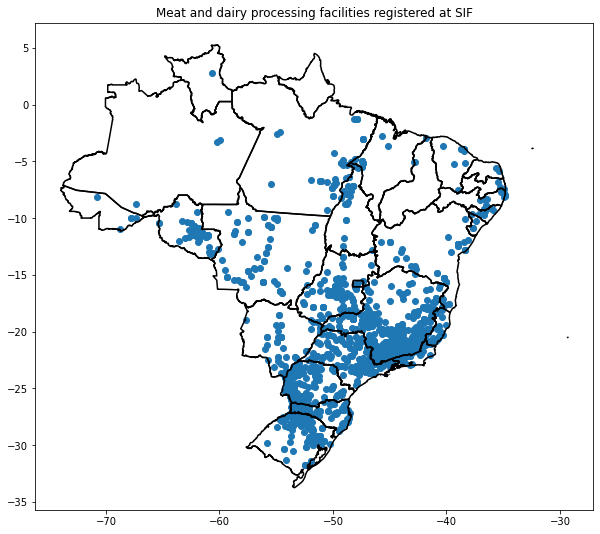

In [10]:
%%capture --no-display 

br_state_borders = gpd.GeoDataFrame.from_file('br_state_borders.json')

fig, ax = plt.subplots(1,1,figsize=(10,10))
br_state_borders.boundary.plot(ax=ax, color='black')
plt.title('Meat and dairy processing facilities registered at SIF')
geo_sif_data.plot(ax=ax)

plt.savefig('BR_SIF_map.png')